# Neural Network learns sine function using autodiff in JAX

<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Google_JAX_logo.svg" width=150 />

This jupyter notebook intends to be a hands-on tutorial for the implementation of a simple Multi-Layer Perceptron (MLP) trained by plain gradient descent with derivative information given by (reverse-mode) automatic differentiation. The neural network is trained to mimic the sin function from data.

Simplifications:
- No train-val-test split
- No regularization
- No Stochastic Minibatching
- Simple Gradient Descent with constant learning rate
- No training modifications

Given:

- $x \in \Re^{N \times 1}$ and $y \in \Re^{N \times 1}$ (N pairs of (x, y) samples that somehow follow a sine curve)
- weight matrices and biases with the correct shapes
- sigmoid activation function $\sigma(x) = \frac{1}{1 + e^{-x}}$


Notice the convention of the data matrices being batch x spatial. As such, weight matrices have to be right-multiplied in order to affect the spatial dimensions.

## Forward Pass

$$
\begin{aligned}
y_1 &= x \cdot W_1
\\
\tilde{y}_1 &= y_1 + b_1
\\
\hat{y}_1 &= \sigma(\tilde{y}_1)
\end{aligned}
$$

$$
\begin{aligned}
y_2 &= \hat{y}_1 \cdot W_2
\\
\tilde{y}_2 &= y_2 + b_2
\\
\hat{y}_2 &= \sigma(\tilde{y}_2)
\end{aligned}
$$

$$
\begin{aligned}
y_3 &= \hat{y}_2 \cdot W_3
\\
\tilde{y}_3 &= y_3 + b_3
\\
\hat{y}_3 &= \sigma(\tilde{y}_3)
\end{aligned}
$$

$$
\begin{aligned}
y_4 &= \hat{y}_3 \cdot W_4
\\
\tilde{y}_4 &= y_4 + b_4
\\
\hat{y}_4 &= I(\tilde{y}_3)
\end{aligned}
$$

$$
L = \frac{1}{2} \text{mean\_over\_all\_axes}((\hat{y}_4 - y)^2)
$$

### Weight Initiliazation

(Xavier Glorot Uniform init)

$$
\begin{aligned}
W_{i,kl} &\propto \mathcal{U}(-lim, lim)
\\
lim &= \sqrt{\frac{6}{\text{fan\_in}_i + \text{fan\_out}_i}}
\\
b_{i,k} &= 0
\end{aligned}
$$

### Learning:

Approximately solve a non-convex optimization problem in the parameter space from a randomized initial estimate.

1. Initialize weights and biases
2. Run forward pass, but through a JAX transformation that also yields a gradient (here for all samples together - no minibatching)
3. Update each parameter with its gradient, e.g., $W_1 \leftarrow W_1 - \eta \bar{W}_1$
4. Repeat until loss is sufficiently decreased

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 30_000

In [3]:
key = jax.random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2 * jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

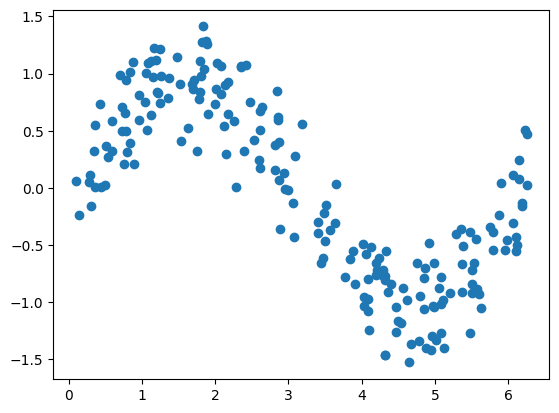

In [5]:
plt.scatter(x_samples, y_samples)

In [6]:
# Weight initiliazation
weight_matrices = []
bias_vectors = []
activation_functions = []

for (fan_in, fan_out) in zip(LAYERS[:-1], LAYERS[1:]):
    kernel_matrix_uniform_limit = jnp.sqrt(6 / (fan_in + fan_out))

    key, wkey = jax.random.split(key)

    W = jax.random.uniform(
        wkey,
        (fan_in, fan_out),
        minval=-kernel_matrix_uniform_limit,
        maxval=+kernel_matrix_uniform_limit,
    )

    b = jnp.zeros(fan_out)

    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(jax.nn.sigmoid)

activation_functions[-1] = lambda x: x

In [7]:
def network_forward(x, weights, biases, activations):
    a = x

    for W, b, f in zip(
        weights,
        biases,
        activations,
    ):
        a = f(a @ W + b)
    
    return a

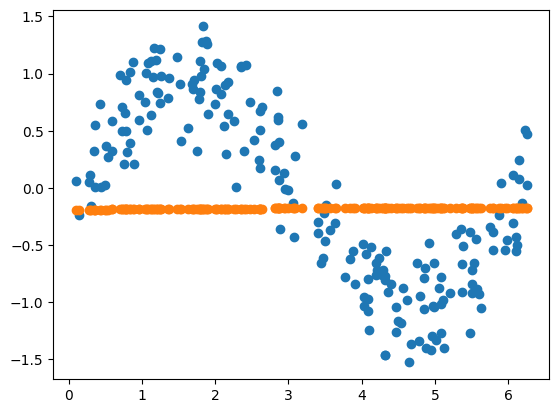

In [8]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))

In [9]:
def loss_forward(y_guess, y_ref):
    delta = y_guess - y_ref
    return 0.5 * jnp.mean(delta**2)

In [10]:
loss_forward(
    network_forward(x_samples, weight_matrices, bias_vectors, activation_functions),
    y_samples
)

Array(0.3169261, dtype=float32)

In [13]:
loss_and_grad_fun = jax.value_and_grad(
    lambda Ws, bs: loss_forward(
        network_forward(
            x_samples,
            Ws,
            bs,
            activation_functions,
        ),
        y_samples,
    ),
    argnums=(0, 1),
)

In [14]:
initial_loss, (initial_weight_gradient, initial_bias_gradient) = loss_and_grad_fun(
    weight_matrices,
    bias_vectors,
)

In [15]:
initial_loss

Array(0.3169261, dtype=float32)

In [16]:
initial_weight_gradient

[Array([[ 7.2213945e-05, -1.8096704e-04, -2.1982470e-03,  3.7786365e-04,
          2.5326079e-03,  1.5415612e-03, -2.2517676e-03,  2.7847683e-04,
         -1.8824994e-05, -2.5364652e-04]], dtype=float32),
 Array([[-0.00186137,  0.00254069,  0.00303164,  0.00068392, -0.00191334,
         -0.00034572, -0.00172571, -0.00117251, -0.00126445,  0.00313279],
        [-0.00177593,  0.00241809,  0.0028959 ,  0.00063861, -0.00183092,
         -0.00032684, -0.00164646, -0.00112519, -0.00121106,  0.00299182],
        [-0.00085401,  0.00124205,  0.00133947,  0.00050296, -0.00079306,
         -0.00020006, -0.00078846, -0.00044838, -0.00051117,  0.00138902],
        [-0.00090233,  0.00130438,  0.00142061,  0.00051174, -0.00084676,
         -0.00020707, -0.00083342, -0.00048307, -0.00054727,  0.00147264],
        [-0.00173393,  0.00235984,  0.00282791,  0.00062118, -0.00178836,
         -0.00031862, -0.00160746, -0.00109964, -0.00118311,  0.0029214 ],
        [-0.00169394,  0.00233274,  0.00274546,  0

In [18]:
loss_and_grad_fun = jax.jit(loss_and_grad_fun)

In [19]:
# Training loop
loss_history = []
for epoch in range(N_EPOCHS):
    loss, (weight_gradients, bias_gradients) = loss_and_grad_fun(
        weight_matrices,
        bias_vectors,
    )

    weight_matrices = jax.tree_map(
        lambda W, W_grad: W - LEARNING_RATE * W_grad,
        weight_matrices,
        weight_gradients
    )
    bias_vectors = jax.tree_map(
        lambda b, b_grad: b - LEARNING_RATE * b_grad,
        bias_vectors,
        bias_gradients,
    )

    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss}")
    
    loss_history.append(loss)

epoch: 0, loss: 0.22284099459648132
epoch: 100, loss: 0.18129336833953857
epoch: 200, loss: 0.15051481127738953
epoch: 300, loss: 0.13804425299167633
epoch: 400, loss: 0.13380441069602966
epoch: 500, loss: 0.1318942755460739
epoch: 600, loss: 0.1306501030921936
epoch: 700, loss: 0.1295970380306244
epoch: 800, loss: 0.12858381867408752
epoch: 900, loss: 0.12756027281284332
epoch: 1000, loss: 0.12651056051254272
epoch: 1100, loss: 0.12543118000030518
epoch: 1200, loss: 0.12432336807250977
epoch: 1300, loss: 0.1231902688741684
epoch: 1400, loss: 0.12203596532344818
epoch: 1500, loss: 0.12086497992277145
epoch: 1600, loss: 0.11968198418617249
epoch: 1700, loss: 0.11849166452884674
epoch: 1800, loss: 0.1172986552119255
epoch: 1900, loss: 0.11610740423202515
epoch: 2000, loss: 0.11492209881544113
epoch: 2100, loss: 0.11374662071466446
epoch: 2200, loss: 0.11258453130722046
epoch: 2300, loss: 0.11143899708986282
epoch: 2400, loss: 0.11031276732683182
epoch: 2500, loss: 0.10920818150043488
epo

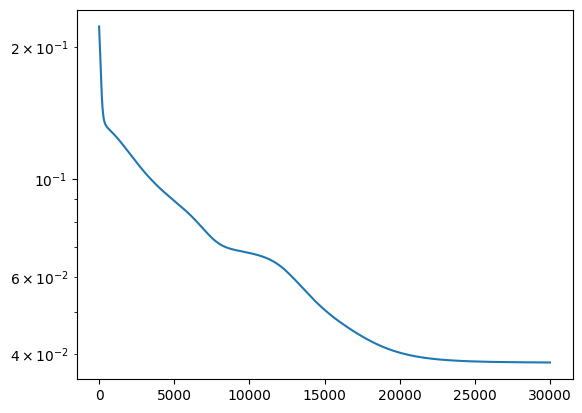

In [20]:
plt.plot(loss_history)
plt.yscale("log")

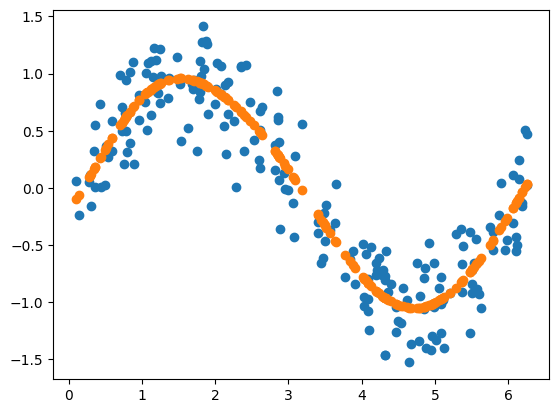

In [21]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))